In [ ]:
pip install -U jax[cuda11_cudnn82] -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 15.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
INFO: pip is looking at multiple versions of jax[cuda11-cudnn82] to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 67.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 MB 5.5 MB/s eta 0:00:00
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.4.7+cuda11.cudnn86
    Uninstalling jaxlib-0.4.7+cuda11.cudnn86:
      Success

In [ ]:
import jax.numpy as jnp
from jax import grad, random, jit
from jax.example_libraries.optimizers import adam
from jax.nn import sigmoid
from jax.nn import relu
import numpy as np
import jax.scipy as jsc
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
size_data = 28
d_data = size_data * size_data # the dimension of a datapoint x
d_latent = 16 # the dimension of the hidden variables in the encoder/decoder
d_z = 2 # the dimension of the latent variable z
min_prob = 1e-6
max_prob = 1 - min_prob
epochs = 100

In [ ]:
def loaddata():
    train = []
    test = []
    anomaly = []
    train_y = []
    test_y = []
    with open('train.txt','r') as f:
        lines = f.readlines()
        for line in lines:
            ar = line.split()
            ar = [float(a) for a in ar]
            train.append(jnp.array(ar))
    with open('train_label.txt','r') as f:
        lines = f.readlines()
        for line in lines:
            train_y.append(int(line))
    with open('test.txt','r') as f:
        lines = f.readlines()
        for line in lines:
            ar = line.split()
            ar = [float(a) for a in ar]
            test.append(jnp.array(ar))
    with open('test_label.txt','r') as f:
        lines = f.readlines()
        for line in lines:
            test_y.append(int(line))
    with open('anomaly.txt','r') as f:
        lines = f.readlines()
        for line in lines:
            ar = line.split()
            ar = [float(a) for a in ar]
            anomaly.append(jnp.array(ar))
    return train,train_y, test, test_y, anomaly

In [ ]:
rng_key = random.PRNGKey(0)
ranges = [d_z*d_latent, d_latent, d_latent*d_data, d_data, d_latent*d_data, d_latent,d_z*d_latent,d_z]
ranges = np.cumsum(ranges)
d_parameters = ranges[-1]


In [ ]:
def v2par(v):
    w1 = jnp.reshape(v[:ranges[0]],(d_latent, d_z))
    b1 = jnp.reshape(v[ranges[0]:ranges[1]],(d_latent))
    w2 = jnp.reshape(v[ranges[1]:ranges[2]],(d_data, d_latent))
    b2 = jnp.reshape(v[ranges[2]:ranges[3]],(d_data))
    w3 = jnp.reshape(v[ranges[3]:ranges[4]],(d_latent, d_data))
    b3 = jnp.reshape(v[ranges[4]:ranges[5]],(d_latent))
    w4 = jnp.reshape(v[ranges[5]:ranges[6]],(d_z, d_latent))
    b4 = jnp.reshape(v[ranges[6]:],(d_z))
    return w1,b1,w2,b2,w3,b3,w4,b4

In [ ]:
# par2v packs all the parameters into a vector v
def par2v(w1,b1,w2,b2,w3,b3,w4,b4):
    res = jnp.append(w1, b1)
    res = jnp.append(res, w2)
    res = jnp.append(res, b2)
    res = jnp.append(res, w3)
    res = jnp.append(res, b3)
    res = jnp.append(res, w4)
    return jnp.append(res, b4)

In [ ]:
# estimate the elbo given x with a single sample of \epsilon
# You need to implement something here
def f(z, w1, b1, w2, b2):
    ##### WRITE YOUR CODE HERE #####
    h1 = jnp.dot(w1, z) + b1
    h2 = relu(h1)
    y = jnp.dot(w2, h2) + b2
    ##### END YOUR CODE #####
    return jnp.clip(sigmoid(y),min_prob,max_prob)

def g(x, w3, b3, w4, b4):
    ##### WRITE YOUR CODE HERE #####

    h3 = jnp.dot(w3, x) + b3
    h4 = relu(h3)
    y = jnp.dot(w4, h4) + b4
    ##### END YOUR CODE #####
    return y

def elbo_estimator(v, epsilon, x):
    w1,b1,w2,b2,w3,b3,w4,b4 = v2par(v)
    e = epsilon
    z = 0.1 * e + g(x,w3,b3,w4,b4)
    x = jnp.clip(x,min_prob,max_prob)
    log_p_z = jsc.stats.multivariate_normal.logpdf(z, mean=jnp.zeros(d_z), cov=jnp.eye(d_z))
    log_p_x_given_z = jnp.sum(x * jnp.log(f(z,w1,b1,w2,b2)) + (1-x) * jnp.log(1-f(z,w1,b1,w2,b2)))
    log_q_z_given_x = jsc.stats.multivariate_normal.logpdf(z, mean=g(x,w3,b3,w4,b4), cov=0.01*jnp.eye(d_z))
    # You may use the following line to ensure numerical stability
    
    ##### WRITE YOUR CODE HERE #####
    elbo = log_p_z + log_p_x_given_z - log_q_z_given_x
    ##### END YOUR CODE #####
    return elbo


In [ ]:
elbo_gradient = jit(grad(elbo_estimator,argnums=(0))) # the auto-diff command in JAX

In [ ]:
train, train_y, test, test_y, anomaly = loaddata()

In [ ]:
# Question 3
# elbo_gradient is a function that has the same input as elbo_estimator but returns the gradients with respect to v
# Set the parameters, v and x first and call elbo_gradient

# You need to implement something here
# What is the gradient for the ELBO w.r.t. b_4 for the first datapoint in training set?
##### WRITE YOUR CODE HERE #####
v = jnp.zeros(d_parameters)
x = train[0]
epsilon = jnp.array([1, 1])

# Compute gradient of ELBO with respect to v
grad_v = elbo_gradient(v, epsilon, x)

# Extract value of dELBO/db4
w1,b1,w2,b2,w3,b3,w4, db4 = v2par(grad_v)
print(db4)
##### END YOUR CODE #####

[-0.10000038 -0.10000038]


In [ ]:
# Question 4
# The codes here are the minimal codes for training, to answer question 4, you need to add codes after each epoch
rng_key, key = random.split(rng_key)
v = 0.1 * random.normal(key, (d_parameters,)) # random initialization
init, update, get_params = adam(1e-3)
state = init(v) # the initial state of training, which includes not only v, but also some parameters for the optimizer
step = 0
elbo_per_epoch_train = np.zeros(epochs)
elbo_per_epoch_test = np.zeros(epochs)
for i in range(epochs):
    # train
    elbo_train_sum = 0
    for x in tqdm(train): # tqdm is a library that makes a progress bar for the loop
        rng_key, key = random.split(rng_key)
        epsilon = random.normal(key, (d_z,)) # generate epsilon for this datapoint
        grad_v = elbo_gradient(v, epsilon, x) # evaluate the gradients
        state = update(step, -grad_v, state) # update the parameters. Since we are maximizing the ELBO, we reverse the gradients here
        step += 1
        v = get_params(state) # get_params is for retrieving the parameters from state
        
       
        ##### WRITE YOUR CODE HERE #####
        elbo_train_sum += elbo_estimator(v,epsilon,x)
        ##### END YOUR CODE #####
  
    
    # test
    v = get_params(state)
    elbo_test_sum = 0
    for sample in test:
      rng_key, key = random.split(rng_key)
      epsilon = random.normal(key, (d_z,))

      ##### WRITE YOUR CODE HERE #####
      elbo_test_sum += elbo_estimator(v, epsilon, sample)
      ##### END YOUR CODE #####

    elbo_per_epoch_train[i] = elbo_train_sum / len(train)
    elbo_per_epoch_test[i] = elbo_test_sum / len(test)
   

100%|██████████| 500/500 [00:30<00:00, 16.16it/s]


Text(0, 0.5, 'Average ELBO Value')

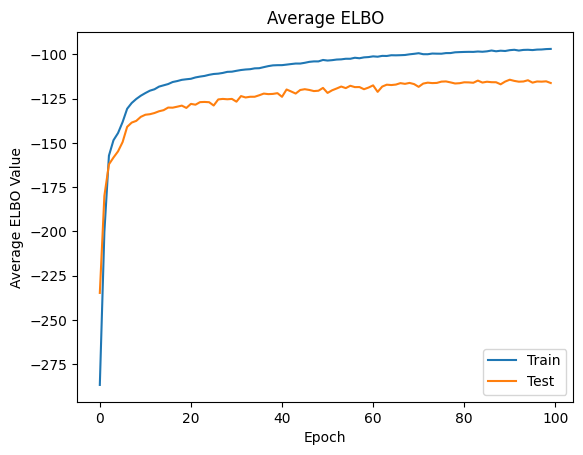

In [ ]:
# Plot Solution
plt.figure()
plt.plot(range(epochs), elbo_per_epoch_train)
plt.plot(range(epochs), elbo_per_epoch_test)
plt.title("Average ELBO")
plt.legend(["Train","Test"])
plt.xlabel("Epoch")
plt.ylabel("Average ELBO Value")

In [ ]:
v = get_params(state)
w1, b1, w2, b2, w3, b3, w4, b4 = v2par(v)



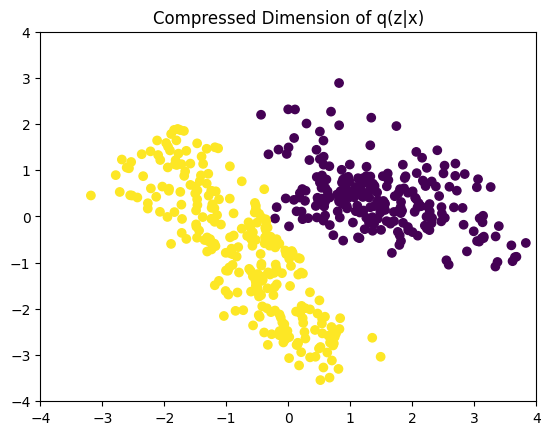

<Figure size 640x480 with 0 Axes>

In [ ]:
def plotCompressedData(compdata, complabels):
    
    compressedData = np.zeros((len(compdata), 2))
    ##### WRITE YOUR CODE HERE #####
    for i, x in enumerate(compdata):
        z_mean = g(x, w3, b3, w4, b4)
        compressedData[i] = z_mean
    ##### END YOUR CODE #####
    plt.scatter(compressedData[:, 0], compressedData[:, 1], c=complabels)
    plt.xlim([-4, 4])
    plt.ylim([-4, 4])
    plt.title("Compressed Dimension of q(z|x)")
    plt.draw()
    plt.show()
    plt.clf()


plotCompressedData(test, test_y)

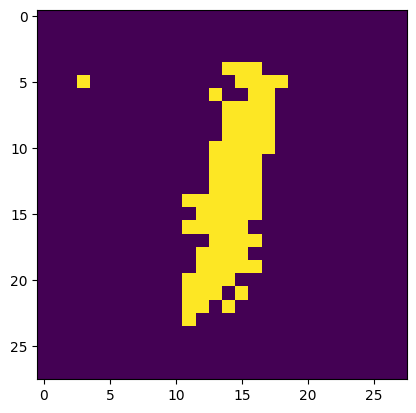

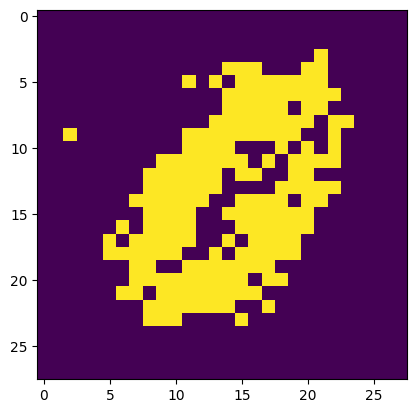

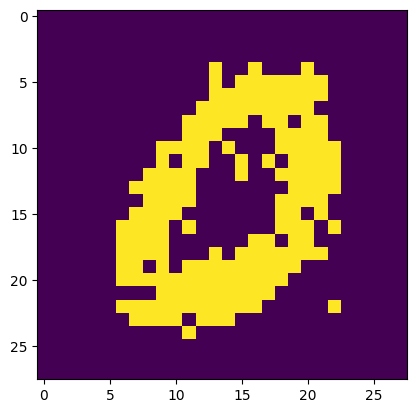

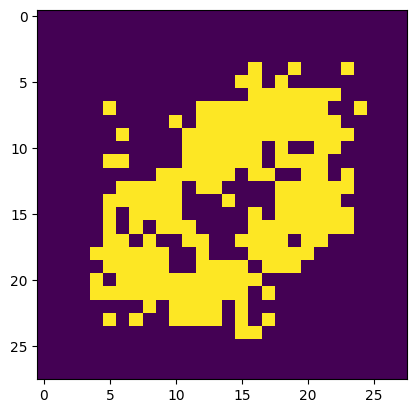

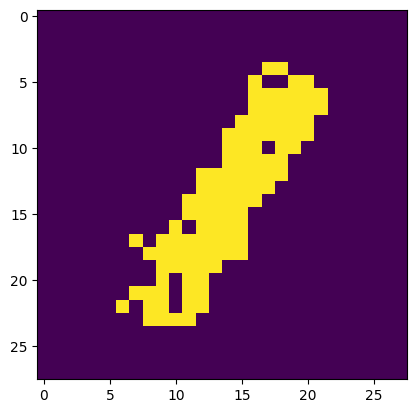

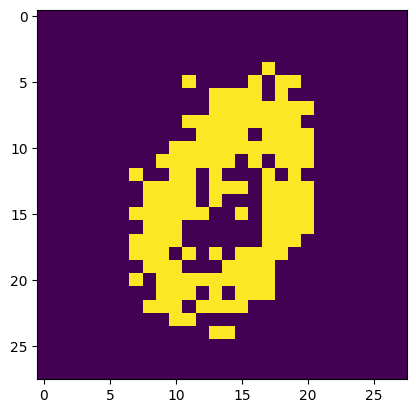

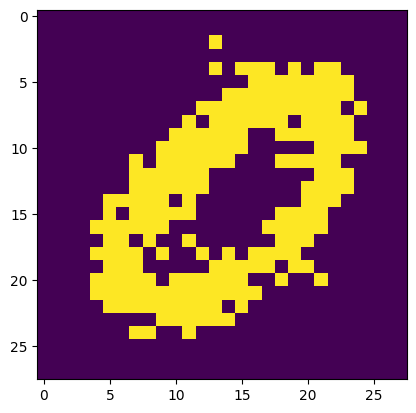

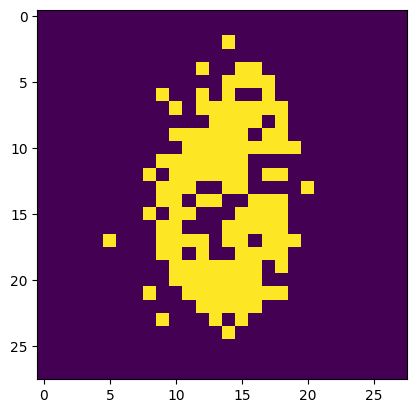

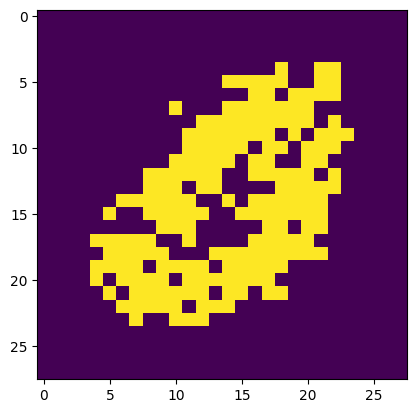

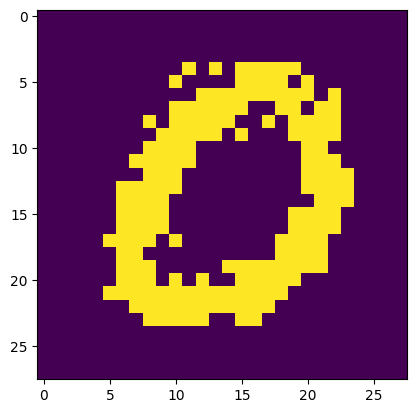

<Figure size 640x480 with 0 Axes>

In [ ]:
for im in range(10):
    rng_key, key = random.split(rng_key)

    ##### WRITE YOUR CODE HERE #####
    # Sample z from prior distribution p(z)
    z = random.normal(key, (d_z,))
    
    # Compute mean of likelihood function p(x|z)
    x_mean = f(z, w1, b1, w2, b2)
    
    # Sample x from likelihood function p(x|z)
    x = random.bernoulli(key, x_mean)
    ##### END YOUR CODE #####

    plt.imshow(x.reshape(28, 28))
    plt.show()
    plt.clf()